# SPACESHIP TITANIC WITH TENSORFLOW

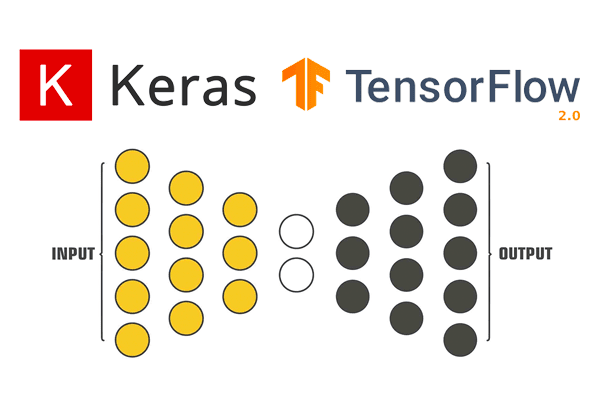

# IMPORTS

In [ ]:
# !pip install keras_tuner

In [ ]:
# Keras & Tensorflow libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import keras_tuner as kt

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# sklearn libraries
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder, Normalizer, StandardScaler

## OPERATING THE KAGGLE API IN GOOGLE COLAB

In [ ]:
from google.colab import files
files.upload() #upload kaggle.json

!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

!kaggle kernels list — user YOUR_USER — sort-by dateRun

!kaggle competitions download -c spaceship-titanic

In [ ]:
!unzip spaceship-titanic.zip 

# DATA

In [ ]:
train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

In [ ]:
train.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [ ]:
train.describe(include='all')

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
count,8693,8492,8476,8494,8511,8514.000000,8490,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000,8493,8693
unique,8693,3,2,6560,3,NaN,2,NaN,NaN,NaN,NaN,NaN,8473,2
top,0001_01,Earth,False,G/734/S,TRAPPIST-1e,NaN,False,NaN,NaN,NaN,NaN,NaN,Gollux Reedall,True
freq,1,4602,5439,8,5915,NaN,8291,NaN,NaN,NaN,NaN,NaN,2,4378
mean,NaN,NaN,NaN,NaN,NaN,28.827930,NaN,224.687617,458.077203,173.729169,311.138778,304.854791,NaN,NaN
std,NaN,NaN,NaN,NaN,NaN,14.489021,NaN,666.717663,1611.489240,604.696458,1136.705535,1145.717189,NaN,NaN
min,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
25%,NaN,NaN,NaN,NaN,NaN,19.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
50%,NaN,NaN,NaN,NaN,NaN,27.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,NaN,NaN
75%,NaN,NaN,NaN,NaN,NaN,38.000000,NaN,47.000000,76.000000,27.000000,59.000000,46.000000,NaN,NaN


In [ ]:
train.isna().sum()

In [ ]:
train.info()

## DATA PREPROCESSING

Here, we'll do some pre-processing which involves filling the missing values.

In [ ]:
imputer_cols = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck" ,"RoomService"]
imputer = SimpleImputer()
imputer.fit(train[imputer_cols])
train[imputer_cols] = imputer.transform(train[imputer_cols])
test[imputer_cols] = imputer.transform(test[imputer_cols])

In [ ]:
train['HomePlanet'].fillna('Earth', inplace=True)
train['CryoSleep'].fillna('False', inplace=True)
train['Cabin'].fillna('None', inplace=True)
train['Destination'].fillna('TRAPPIST-1e', inplace=True)
train['VIP'].fillna('False', inplace=True)

test['HomePlanet'].fillna('Earth', inplace=True)
test['CryoSleep'].fillna('False', inplace=True)
test['Cabin'].fillna('G/109/P', inplace=True)
test['Destination'].fillna('TRAPPIST-1e', inplace=True)
test['VIP'].fillna('False', inplace=True)

train['Name'].fillna('no name', inplace=True)
test['Name'].fillna('no name', inplace=True)

## FEATURE ENGINEERING

We'll be doing some feature engineering by creating new features out of the others.

In [ ]:
train['Deck'] = train['Cabin'].apply(lambda x:str(x)[:1])
train['Side'] = train['Cabin'].apply(lambda x:str(x)[-1:])
test['Deck'] = train['Cabin'].apply(lambda x:str(x)[:1])
test['Side'] = train['Cabin'].apply(lambda x:str(x)[-1:])

train['PGroup'] = train['PassengerId'].apply(lambda x: x.split('_')[0])
train['PNumber'] = train['PassengerId'].apply(lambda x: x.split('_')[1])
test['PGroup'] = test['PassengerId'].apply(lambda x: x.split('_')[0])
test['PNumber'] = test['PassengerId'].apply(lambda x: x.split('_')[1])

train['LastName'] = train['Name'].apply(lambda x:x.split(" ")[1])
test['LastName'] = train['Name'].apply(lambda x:x.split(" ")[1])

train['AllServices'] = train['RoomService'] + train['FoodCourt'] + train['ShoppingMall'] + train['Spa'] + train['VRDeck']
test['AllServices'] = test['RoomService'] + test['FoodCourt'] + test['ShoppingMall'] + test['Spa'] + test['VRDeck']

As machine learning models only love numbers, we'll encode the categorical columns using **Label Encoder**.

In [ ]:
label_cols = ["HomePlanet", "CryoSleep", "Destination" ,"VIP", "Deck", "Side", "LastName", "PGroup", "PNumber"]

for i in label_cols:
    train[i] = train[i].astype(str)
    test[i] = test[i].astype(str)
    train[i] = LabelEncoder().fit_transform(train[i])
    test[i] = LabelEncoder().fit_transform(test[i])

In [ ]:
train['Transported'] = LabelEncoder().fit_transform(train['Transported'])
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,Deck,Side,PGroup,PNumber,LastName,AllServices
0,0001_01,1,0,B/0/P,2,39.0,0,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,0,1,0,0,0,1431,0.0
1,0002_01,0,0,F/0/S,2,24.0,0,109.0,9.0,25.0,549.0,44.0,Juanna Vines,1,5,1,1,0,2109,736.0
2,0003_01,1,0,A/0/S,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,0,0,1,2,0,1990,10383.0
3,0003_02,1,0,A/0/S,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,0,0,1,2,1,1990,5176.0
4,0004_01,0,0,F/1/S,2,16.0,0,303.0,70.0,151.0,565.0,2.0,Willy Santantines,1,5,1,3,0,1778,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,1,0,A/98/P,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,0,0,0,6213,0,1416,8536.0
8689,9278_01,0,1,G/1499/S,1,18.0,0,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,0,6,1,6214,0,1341,0.0
8690,9279_01,0,0,G/1500/S,2,26.0,0,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,1,6,1,6215,0,470,1873.0
8691,9280_01,1,0,E/608/S,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,0,4,1,6216,0,996,4637.0


## PREPARING DATA FOR MODEL TRAINING

We'll drop following columns as they are no longer needed now as we have made features out of them.

In [ ]:
cols_to_drop = ['Name', 'PassengerId', 'Cabin']

In [ ]:
y = train['Transported']
train.drop(['Name', 'PassengerId', 'Cabin', 'Transported'], axis=1, inplace=True)

In [ ]:
transformer = Normalizer().fit(train) 
transformer
train=transformer.transform(train)

Then, we can split the data into training and validation sets. This will help our model to train on the training dataset & evaluate the performance simultaneously on the validation dataset.

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(train, y, test_size=0.3, random_state=101)

In [ ]:
ids = test['PassengerId']
test.drop(cols_to_drop, axis=1, inplace=True)

We have to perform the normalization step for our final test dataset also.

In [ ]:
transformer = Normalizer().fit(test) 
transformer
test=transformer.transform(test)

# MODEL ARCHITECTURE

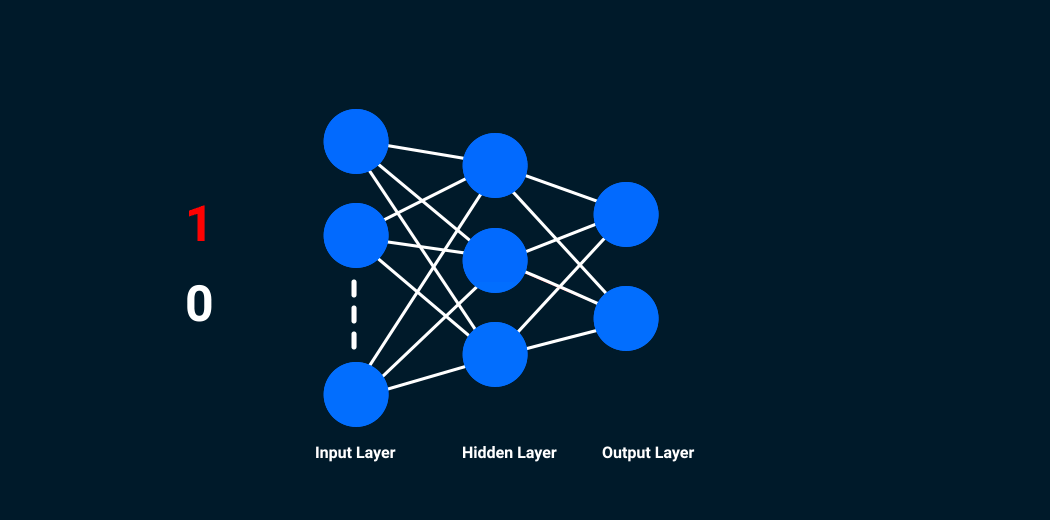

We'll use Keras, with Tensorflow as backend, to create the neural network model & perform the training.

<div class="alert alert-block alert-info">
<p style='font-size: 17px'>Before the model, let's define some terms:</p>

<p style='font-size: 17px'><strong>Sequential</strong> : Sequential class groups a linear stack of layers to form a model on which training & inference can be done.</p>

<p style='font-size: 17px'><strong>Dense</strong>: Dense is a densely-connected (look at the figure) neural network layer.</p>

<p style='font-size: 17px'><strong>activation</strong>: The type of function to perform mathematical operations on the layers. We'll be using <strong>sigmoid</strong> activation function to yield the value between 0 and 1.</p>

<p style='font-size: 17px'><strong>input_dims</strong>: The shape of the values that are being passed.</p>

<p style='font-size: 17px'><strong>kernel_initializer</strong>: Initializers define the way to set the initial random weights of Keras layers.</p>

<p style='font-size: 17px'><strong>units</strong>: It is a positive integer & is used to define the dimensionality of the output space. </p>

In [ ]:
print(f'The dimension of data is: {x_train.shape[1]}')

The dimension of data is: 16


In [ ]:
model = Sequential([
    Dense(units=32, input_dim=16, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=32, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=5, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=1, kernel_initializer = 'uniform', activation='sigmoid')
    ])

We can print out how our model looks or in short, it's summary, by running the following code:

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 32)                1056      
                                                                 
 dense_6 (Dense)             (None, 5)                 165       
                                                                 
 dense_7 (Dense)             (None, 1)                 6         
                                                                 
Total params: 1,771
Trainable params: 1,771
Non-trainable params: 0
_________________________________________________________________


## MODEL TRAINING (W/ HYPERPARAMETER TUNING)

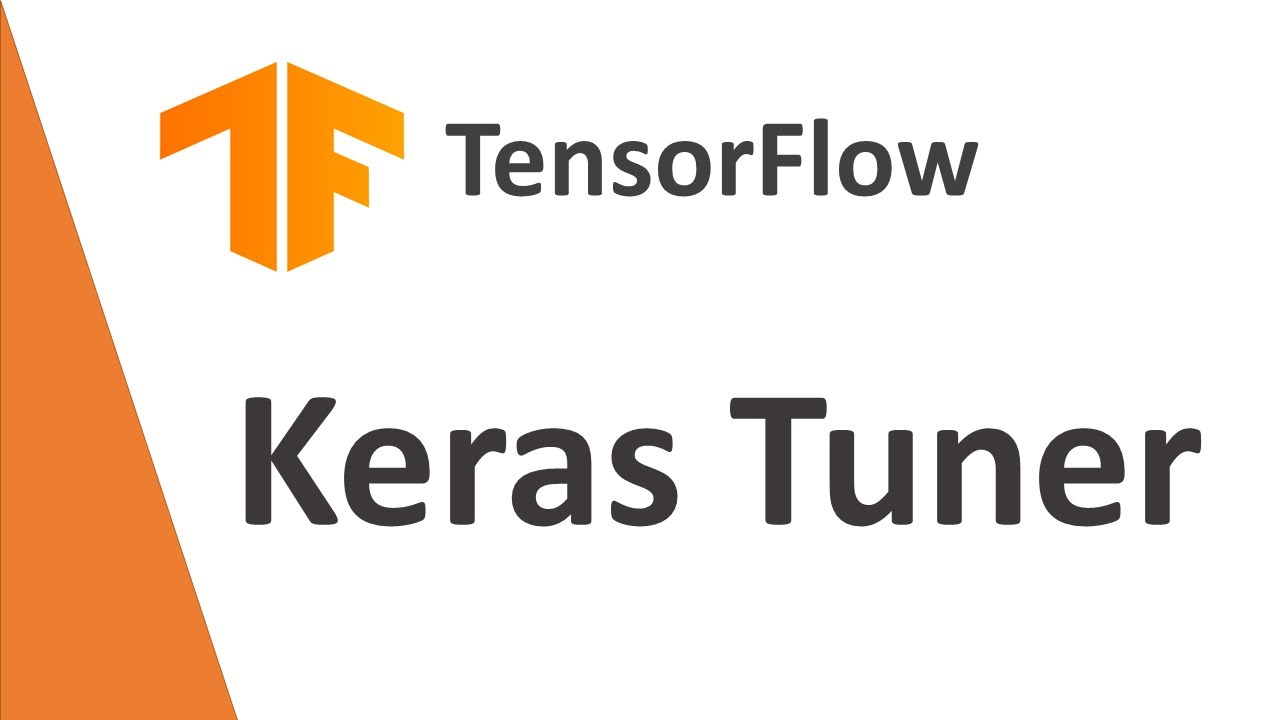

📌 KerasTuner is an easy-to-use, scalable hyperparameter optimization framework that solves the pain points of hyperparameter search.

For this, we define a function and use the hp argument to define the hyperparameters during model creation. Here, I have defined hyperparameter space for learning rate.

In [ ]:
def build_model(hp):
    lrate = hp.Float('lrate', 1e-4, 1e-1, sampling='log') # learning rate hyper-param space
    
    model = Sequential([
    Dense(units=32, input_dim=16, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=32, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=5, kernel_initializer = 'uniform', activation='relu'),
    Dense(units=1, kernel_initializer = 'uniform', activation='sigmoid')
    ])
    
    model.compile(optimizer=Adam(learning_rate=lrate), loss='binary_crossentropy', metrics=['accuracy'])
    return model

Then, we need to choose a tuner class. It can be any of these: **RandomSearch**, **BayesianOptimization** and **Hyperband**.

We'll be going with the **BayesianOptimization**.

Then, we declare the model function, objective function and maximum trials. Here, setting overwrite=True will start a new search and ignore any previous results.

In [ ]:
tuner = kt.BayesianOptimization(
    build_model,
    objective=kt.Objective('val_accuracy', 'max'),
    max_trials=10,
    num_initial_points=2,
    overwrite=True
)

And then we search through that hyperparameters space. The syntax is quite similar to the tensorflow-keras predict function.

In [ ]:
tuner.search(
    x_train, y_train, epochs=5, validation_data=(x_valid, y_valid)
)

Trial 10 Complete [00h 00m 04s]
val_accuracy: 0.7925613522529602

Best val_accuracy So Far: 0.7956288456916809
Total elapsed time: 00h 01m 18s


Now, our tuner has searched through our own defined hyperparameter space. To get the best model, we just run the get_best_model[0] to get the model having the best objective function result.

In [ ]:
best_model = tuner.get_best_models()[0]

And then, we perform the fit on that best model and validate on our validation set for our final training part.

In [ ]:
hist = best_model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=10, batch_size=1)

Epoch 1/10
6085/6085 [==============================] - 18s 3ms/step - loss: 0.5524 - accuracy: 0.7504 - val_loss: 0.5177 - val_accuracy: 0.7803
Epoch 2/10
6085/6085 [==============================] - 18s 3ms/step - loss: 0.5361 - accuracy: 0.7668 - val_loss: 0.5501 - val_accuracy: 0.7945
Epoch 3/10
6085/6085 [==============================] - 18s 3ms/step - loss: 0.5438 - accuracy: 0.7638 - val_loss: 0.5360 - val_accuracy: 0.7949
Epoch 4/10
6085/6085 [==============================] - 15s 2ms/step - loss: 0.5315 - accuracy: 0.7734 - val_loss: 0.5088 - val_accuracy: 0.7929
Epoch 5/10
6085/6085 [==============================] - 18s 3ms/step - loss: 0.5343 - accuracy: 0.7688 - val_loss: 0.4980 - val_accuracy: 0.7910
Epoch 6/10
6085/6085 [==============================] - 16s 3ms/step - loss: 0.5371 - accuracy: 0.7658 - val_loss: 0.4971 - val_accuracy: 0.7891
Epoch 7/10
6085/6085 [==============================] - 18s 3ms/step - loss: 0.5301 - accuracy: 0.7699 - val_loss: 0.5090 - val_ac

## MODEL EVALUATION

In [ ]:
pred = best_model.predict(x_valid, batch_size=1, verbose=0)
pred[:5]

array([[0.707603  ],
       [0.16177617],
       [0.16177617],
       [0.56831807],
       [0.16177617]], dtype=float32)

We see that our predictions are there but they are continuous values and not in the binary form that we want. That's because we have sigmoid as our activation function in our last layer. It yields the value between 0 & 1.

So, in order to make it in binary form, we can define a point above which that value will be made 1 and below which it will be made 0.

Here, we take that point as 0.5.

In [ ]:
y_pred = [1 if x > 0.5 else 0 for x in pred]
y_pred[:5]

[1, 0, 0, 1, 0]

### PLOTTING ACCURACY AND LOSS PLOTS

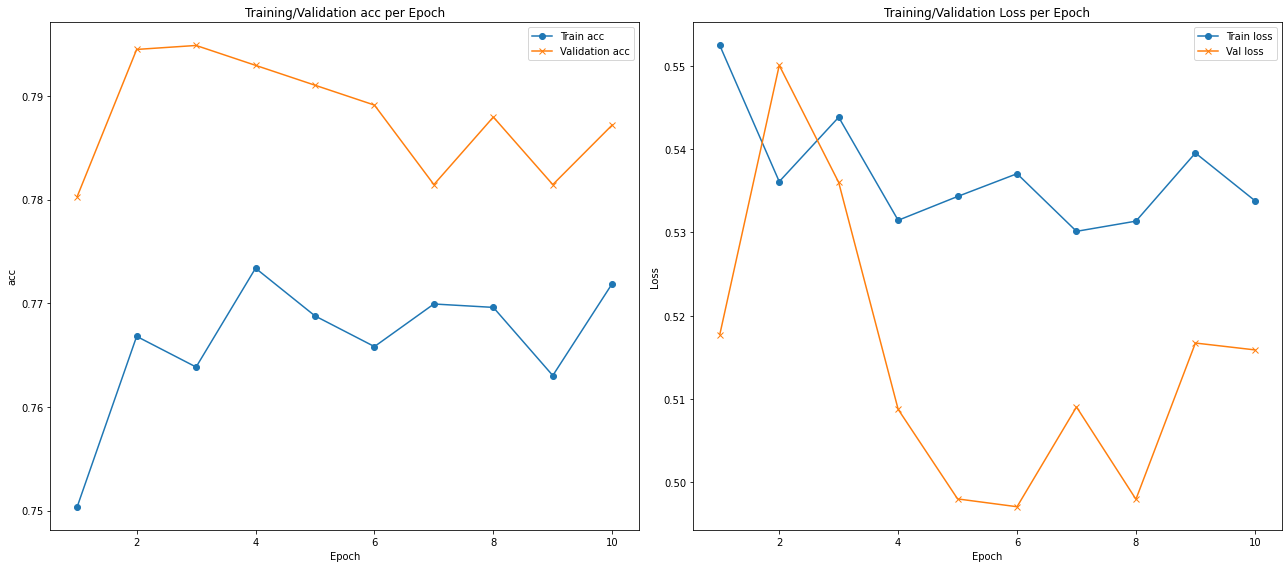

In [ ]:
f, ax = plt.subplots(1, 2, figsize=[18, 8])
ax[0].plot([None] + hist.history['accuracy'], 'o-')
ax[0].plot([None] + hist.history['val_accuracy'], 'x-')
# Plot legend and use the best location automatically: loc = 0.
ax[0].legend(['Train acc', 'Validation acc'], loc = 0)
ax[0].set_title('Training/Validation acc per Epoch')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('acc')

ax[1].plot([None] + hist.history['loss'], 'o-')
ax[1].plot([None] + hist.history['val_loss'], 'x-')

# Plot legend and use the best location automatically: loc = 0.
ax[1].legend(['Train loss', "Val loss"], loc = 0)
ax[1].set_title('Training/Validation Loss per Epoch')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')

plt.tight_layout()
plt.show()

### CONFUSION MATRIX

A confusion matrix is a table that is often used to describe the performance of a classification model on a set of test data for which the true values are known.

In [ ]:
cm = confusion_matrix(y_true=y_valid, y_pred=y_pred)

Now, in order to plot confusion matrix, sklearn now provides a very efficient way. Rather than just going over lines of matplotlib code, we can just import ConfusionMatrixDisplay from the metrics module to directly plot it.

<Figure size 720x576 with 0 Axes>

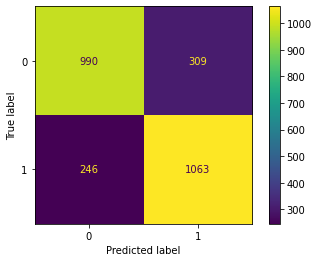

In [ ]:
plt.figure(figsize=[10, 8])
ConfusionMatrixDisplay.from_predictions(y_valid, y_pred)
plt.show()

## FINAL PREDICTIONS

In [ ]:
preds = best_model.predict(test)
preds[:5]

134/134 [==============================] - 0s 1ms/step


array([[0.707603  ],
       [0.16177617],
       [0.707603  ],
       [0.707603  ],
       [0.707603  ]], dtype=float32)

In [ ]:
survived = [1 if x > 0.5 else 0 for x in preds]
survived[:5]

[1, 0, 1, 1, 1]

In [ ]:
for i in range(len(survived)):
    survived[i] = bool(survived[i])

survived[:5]

[True, False, True, True, True]

In [ ]:
subs = pd.DataFrame({'PassengerId': ids, 'Transported': survived})
subs.to_csv('submission.csv', index=False)